# Shiv Yucel

# Part I: Assessing Impact of Summer Temperature and Mobility on US Outbreak of COVID-19 Cases

### Background

Scientific literature on viral infections emphasizes that seasonal trends can influence spread through both human behavior and specific viral properties, such as resilience to different weather conditions (Singer et al. 2017). Existing research on COVID-19 emphasizes that the virus thrives most in cold, dry, and dark conditions (Ratnesar-Shumate et al. 2020). A recent article published in PNAS concluded that due to viral properties of COVID-19, without intervention, growth of cases would drop in the summer as the weather warms and daylight increases, and peak again in the winter (Merow and Urban 2020). This analysis overlooks that changes in human behavior are essential to consider when assessing seasonal risk. Exploring how temperature and mobility measures differ across states, and how they in turn impact the spread of COVID-19, may help to explain why the outcome of this past summer skewed so far from their predictions.

This research paper poses the following question:

> ($RQ_1$): How did the temperature during the summer influence the United States' COVID-19 outbreak indirectly through its impact on human behaviour?

Increased public mobility, including recreational activity, has been seen to positively correlate with COVID-19 transmission (Kim et al. 2020; Salvador et al. 2020). This paper hypothesizes ($H_1$) that states with higher recreational mobility during warmer weather experienced more COVID-19 cases after warmer weather, and vice versa for states with lower recreational mobility during warmer weather.

### Methodology

#### Analysis 1 and 2: Correlation Coefficients of Recreational Mobility, Temperature, and Confirmed Cases

The first analysis calculates and plots correlation coefficients to understand how each US state's recreational mobility changed with temperature during the summer, separating states by their total average summer temperature. The second section correlates confirmed cases with recent prior temperatures, to explore whether states that experience higher mobility during warm weather also experience more confirmed cases after warm weather. When calculating the second correlation coefficient, the analysis takes a rolling average of the temperature on days $t-2$ to $t-10$ to account for the incubation period, as only 2.5% of infected individuals test positive before 2 days, and 97.5% of infected test positive before 10 days from exposure (Lauer et al. 2020).

#### Analysis 3: Temporal Analysis of COVID-19 cases in States with Positive and Negative Recreation-Temperature Correlation Coefficients

The following analysis aims to explore the relationship between recreation and temperature on COVID-19 from a temporal perspective. The visualization separates all US states into two groups based on whether their recreational mobility and temperature correlation coefficients are positive or negative. A side-by-side time-series visualization is produced for each group during the summer, containing the mean of the average temperatures and the mean percent-changes in COVID-19 cases for all states in their respective groups. The 7-day rolling average of each measure is calculated to preserve the general trends without including the noise inherent to such rapidly oscillating measurements. Given our hypothesis ($H_1$), one might expect that confirmed cases in the group with a positive correlation coefficient may follow more closely with the rise in temperature, with a slight lag to account for the incubation period.

#### Data

The county-level temperature is gathered from the WEATHER table in the OxCovid19 Database whose source is the Met Office Informatics LAB (Mahdi et al. 2020). Recreation is measured using Google’s mobility rate measurement from the OxCovid19 MOBILITY table, which measures the relative change on each day from a baseline amount of mobility in public places such as restaurants, cafes, libraries, etc. The baseline is calculated as the median mobility for each day of the week from January 3rd to February 4th, 2020. Recreation activity is the desired measure for this study due its non-essential nature, which makes its attractiveness more susceptible to changes in temperature. The ADMINISTRATIVE_DIVISION table is merged to acquire the names of the states from their GID code, which is not present in the WEATHER table. The second section requires COVID-19 confirmed cases that are merged in from the EPIDEMIOLOGY table in the OxCovid19 Database, which uses the COVID Tracking Project as a state-level source.

## Analysis

### Import Packages and Define Functions

In [ ]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
import seaborn as sns
import matplotlib.pyplot as plt

#set default plotting font sizes
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.rc('font', size=18)  
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18) 
plt.rc('legend', fontsize=12)   
plt.rc('figure', titlesize=20) 


class Analysis1:
    def __init__(self, df):
        #create class dataframe object
        self.df = df
        
    def to_date(self, datevar):
        #get date column as datetime object
        self.df[datevar] = pd.to_datetime(self.df[datevar])
        
    def grouped_corr(self, group, var1, var2):
        #create new df consisting of corr coef for each group 
        #based on var1 and var2 columns
        temp = pd.DataFrame(self.df.groupby(group)[[var1, var2]].corr())
        temp.reset_index(inplace=True)
        cleaned_df = temp.loc[temp['level_1'] == var1, [group, var2]]
        return cleaned_df
    
    def to_celsius(self, temp_col):
        self.df[temp_col] = self.df[temp_col]-273.15
    
    def get_avg_temp(self, geo_var, temp_var):
        #get average summer temperature for each state by taking 
        #mean of all daily avg temperatures
        temp_avg = pd.DataFrame(us_data.groupby(geo_var)[temp_var].mean())
        temp_avg.reset_index(inplace=True)
        return temp_avg
    

    def pct_diff_cases(self, geo_var, covid_var):
        #calculate percent change in daily COVID-19 cases for each state
        self.df['pct_change'] = (self.df.groupby(geo_var)[covid_var].apply
        (pd.Series.pct_change))
        
    def case_diff(self, state_col, case_col):
        #calculate absolute differences in daily COVID-19 cases for each state
        self.df['new_cases'] = self.df.groupby(state_col)[case_col].diff()

    def roll_col(self, rol_val, state_col, name, roll_length=7):
        #create new column which generates rolling average 
        #of rol_val for each state by roll_length (default 7D)
        self.df[name] = self.df.groupby(state_col)[rol_val].transform(lambda x: 
                        x.rolling(roll_length, 1).mean())


    def get_t_minus_x_temp(self, temp_col, state, x):
        #create new column which shifts forward temperatures from t-x, grouping by state
        temp_covid.df[f't_minus_{x}_temp'] = temp_covid.df.groupby(state)[temp_col].shift(x)  
        
    def add_col_for_corr_coefficient_sign(self, corr_col, name):
        #create new column which equals 1 if the corr_coef > 0 in that row, and 0 if not
        self.df[name] = [1 if x>0 else 0 for x in 
                                self.df[corr_col]]
        
    def get_percentile(self, col_name):
        self.df['corr_percentile'] = self.df[col].rank(pct=True)
        
    def compare_timeseries_split_coef(self, date_col, corr_col, covid_col, temp_col):
        #create side-by side plots of average temp_col 
        #for all states where corr_col equal to 1 and 0, respectively
        #layer side-by-side plots of average pct change 
        # in COVID-19 cases (covid_col) for same groups
        
        fig, (ax0, ax2) = plt.subplots(1,2)
        ax0.tick_params(axis= 'x', labelrotation=45)
        ax2.tick_params(axis= 'x', labelrotation=45)
        fig.set_size_inches(13, 8)
        ax1 = ax0.twinx()
        ax2.tick_params(axis= 'x', labelrotation=45)
        ax3 = ax2.twinx()
        a,= ax0.plot(self.df[date_col].unique(), 
                     self.df.loc[self.df[corr_col]==1].
                     groupby(date_col)[covid_col].mean(),
                     'r-', label='Avg % Change Cofirmed Cases')
        b,= ax1.plot(self.df[date_col].unique(), 
                     self.df.loc[self.df[corr_col]==1].
                     groupby(date_col)[temp_col].mean(), 
                     label='7-Day Rolling Temp Average')
        c,= ax2.plot(self.df[date_col].unique(), 
                     self.df.loc[self.df[corr_col]==0].
                     groupby(date_col)[covid_col].mean(), 
                     'r-', label='Avg % Change Cofirmed Cases')
        d,= ax3.plot(self.df[date_col].unique(), 
                     self.df.loc[self.df[corr_col]==0].
                     groupby(date_col)[temp_col].mean(), 
                     label = '7-Day Rolling Temp Average')
        p = [a, b]
        q = [c, d]
        fig.suptitle('Fig.2: Average Temperature and Average Pct Change COVID-19 Cases \n (7 day rolled average)')
        ax0.set_title("Fig.2A: States with Rec Mobility \n and Temp Correlation > 0")
        ax2.set_title("Fig.2B: States with Rec Mobility \n and Temp Correlation <= 0")
        ax1.legend(p, [p_.get_label() for p_ in p])
        ax2.legend(q, [q_.get_label() for q_ in q])
        ax0.get_shared_y_axes().join(ax0, ax2)
        ax1.get_shared_y_axes().join(ax1, ax3)
        ax0.set_ylabel('Mean Percent Change Covid Cases')
        ax3.set_ylabel('Average of Mean Daily Temperature')
        fig.tight_layout()
        plt.subplots_adjust(top=0.8)
        plt.show()


def plot_corr_side_by_side(df1, temp_avg_var1, yvar1, title1, xlabel1, ylabel1, 
                           df2, temp_avg_var2, yvar2, title2, xlabel2, ylabel2):
    #plot both correlation coefficients side by side with average summer temperature on the x-axis
    #shared y-axis for clarity
    sns.set_style('darkgrid')
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(13, 8)
    sns.regplot(data=df1, x=temp_avg_var1, y=yvar1, ax=ax0)
    ax0.set_xlim(df1[temp_avg_var1].min()-0.3, df1[temp_avg_var1].max()+0.3)
    sns.regplot(data=df2, x=temp_avg_var2, y=yvar2, ax=ax1, color='r')
    ax1.set_xlim(df2[temp_avg_var2].min()-0.3, df2[temp_avg_var2].max()+0.3)
    ax0.set_title(title1)
    ax1.set_title(title2)
    ax0.set_xlabel(xlabel1)
    ax0.set_ylabel(ylabel1)
    ax1.set_xlabel(xlabel2)
    ax1.set_ylabel(ylabel2)
    fig.tight_layout()
    plt.show()


### Correlation Coefficients of Recreational Mobility and Temperature at time $t$


#### Acquiring Data

In [ ]:
#connect to OxCovid Database and acquire date, daily temp, state name, mobility from Google 
#for state-level data entries during the summer

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""
SELECT w.DATE, 
w.TEMPERATURE_MEAN_AVG, 
a.ADM_AREA_1, \
m.RETAIL_RECREATION 
FROM weather w JOIN ADMINISTRATIVE_DIVISION a ON w.GID=a.ADM_AREA_1_CODE \
LEFT JOIN MOBILITY m on a.ADM_AREA_1 = m.ADM_AREA_1 AND w.DATE = m.DATE \
WHERE w.date<'2020-09-01' AND w.date>'2020-06-01' AND w.country = 'United States' \
AND a.ADM_AREA_2_CODE is NULL and m.source = 'GOOGLE_MOBILITY'\
and m.ADM_AREA_2 is NULL ORDER BY w.date""")

us_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

#### Wrangling Data and Calculating Correlation Coefs

In [ ]:
#create Analysis1 class object and rename columns
temp_mob_df = Analysis1(us_data)
temp_mob_df.df.rename(columns={'adm_area_1':'state', 'retail_recreation':'recreation_mobility'}, inplace=True)

#get date as datetime type
temp_mob_df.to_date('date')

#get temperature as Celsius
temp_mob_df.to_celsius('temperature_mean_avg')

#create DataFrame of each state and their temperature-recreation corr coef
mob_temp_corr = temp_mob_df.grouped_corr('state', 'temperature_mean_avg', 'recreation_mobility')
mob_temp_corr.rename(columns={'recreation_mobility': 'temp_rec_corrcoef'}, inplace=True)
mob_temp_corr.reset_index(drop=True, inplace=True)

#get average temp per state
avg_summer_temp = temp_mob_df.get_avg_temp('state', 'temperature_mean_avg')

#merge each state's mobility-temp corr coef with average summer temp
mob_temp_corr = Analysis1(mob_temp_corr.merge(avg_summer_temp))

#descriptive statistics and observe max and min corr-coef states
print('\nDescriptive Statistics Corr Coef and Mean Summer Temperatures')
display(mob_temp_corr.df.describe().loc[['mean', 'min', 'max']])
print("Maximum Recreation Mobility-Temperature Corr Coef\n")
display(mob_temp_corr.df.loc[mob_temp_corr.df['temp_rec_corrcoef'] == mob_temp_corr.df['temp_rec_corrcoef'].max()])
print("\nMinimum Recreation Mobility-Temperature Corr Coef\n")
display(mob_temp_corr.df.loc[mob_temp_corr.df['temp_rec_corrcoef'] == mob_temp_corr.df['temp_rec_corrcoef'].min()])



Descriptive Statistics Corr Coef and Mean Summer Temperatures


,temp_rec_corrcoef,temperature_mean_avg
mean,-0.023710,22.508514
min,-0.471293,10.847265
max,0.380228,28.165695


Maximum Recreation Mobility-Temperature Corr Coef



,state,temp_rec_corrcoef,temperature_mean_avg
30,New Jersey,0.380228,23.519189



Minimum Recreation Mobility-Temperature Corr Coef



,state,temp_rec_corrcoef,temperature_mean_avg
2,Arizona,-0.471293,26.899267


### Correlation Coefficient of COVID-19 Cases at time $t$ and Avg Temperature at time $t-2$ to $t-10$ 

#### Acquiring Data 

In [ ]:
#connect to OxCovid Database and acquire date, daily mean temp, state name, confirmed cases, merged on state for (2020-05-01 to 2020-09-01)
#ADMINISTRATIVE_DIVISION required to identify state names in EPIDEMIOLOGY, the rest joined on state and date.
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT \
w.COUNTRYCODE, \
w.DATE, \
w.TEMPERATURE_MEAN_AVG, \
a.ADM_AREA_1, \
e.CONFIRMED \
FROM weather w JOIN ADMINISTRATIVE_DIVISION a ON w.GID=a.ADM_AREA_1_CODE \
LEFT JOIN EPIDEMIOLOGY e on a.ADM_AREA_1 = e.ADM_AREA_1 AND w.DATE = e.DATE \
WHERE w.date<'2020-09-01' AND w.date>'2020-05-28' AND w.country = 'United States' \
AND a.ADM_AREA_2_CODE is NULL \
and e.ADM_AREA_2 is NULL AND e.SOURCE = 'USA_CTP' ORDER BY w.date""")

temp_covid = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

##### Data Wrangling and Calculating Correlation Coefficients

In [ ]:
#create Analysis class object of daily temperature and COVID-19 cases for each state
temp_covid = Analysis1(temp_covid)
temp_covid.df.rename(columns = {'adm_area_1':'state'}, inplace=True)

#get date as datetime type
temp_covid.to_date('date')

#get temperature as Celsius
temp_covid.to_celsius('temperature_mean_avg')

#get daily percent different in COVID-19 cases for each state starting from before June 1st to prevent distorted pct_change first value
temp_covid.pct_diff_cases('state', 'confirmed')

#create new Analysis object beginning at entry of summer
temp_covid = Analysis1(temp_covid.df.loc[temp_covid.df['date']>'2020-06-01'])

#create t-2 temp by shifting daily temp for each state forward by 2 days
temp_covid.get_t_minus_x_temp('temperature_mean_avg', 'state', 2)

#create t-2 to t-10 rolled average temp for each state
temp_covid.roll_col('t_minus_2_temp', 'state', 't_minus_2_8d_roll', 8)

#create corr coef DataFrame for each state between COVID cases at time t and average temp from time t-2 to t-10
temp_covid_corr=temp_covid.grouped_corr('state', 't_minus_2_8d_roll', 'pct_change')
temp_covid_corr.rename(columns={'pct_change':'temp_covid_corr'}, inplace=True)

#create merged Analysis1 object which contains each state, their corr coef, and their average summer temp
temp_covid_corr = Analysis1(temp_covid_corr.merge(avg_summer_temp, how ='left', left_on = 'state', right_on='state'))

### Temporal Exploration of Cases and Temperature Change


In [ ]:
#add binary column showing whether each state has a positive or negative recreation mobility - temperature correlation coefficient
mob_temp_corr.add_col_for_corr_coefficient_sign('temp_rec_corrcoef', 'rec_temp_coef_sign')

#create slice of two variables of interest: state and binary variable
mob_temp_slice = mob_temp_corr.df[['state', 'rec_temp_coef_sign']]

#merge into master dataframe with date, daily temp, state, pct_change in COVID-19 cases, and rec-temp corr coef sign
temp_covid_rec_master = Analysis1(temp_covid.df.merge(mob_temp_slice, left_on='state', right_on='state'))

#create 7D rolled average for both daily temp mean and pct_change COVID-19 cases for each state
temp_covid_rec_master.roll_col('temperature_mean_avg', 'state', 'weekly_rolled_temp', roll_length=7)
temp_covid_rec_master.roll_col('pct_change', 'state', 'weekly_rolled_cases', roll_length=7)

## Results and Discussion
### Analyses 1 & 2
The two plots in `Figure 1` represent the outputs of the two correlation coefficients for each state, plotted against the average of mean daily temperatures during the summer season in each state. The `Figure 1A` y-axis depicts the correlation coefficient for recreational mobility at time $t$ and mean temperature at time $t$. The shaded area surrounding the regression line represents a 95% confidence interval. The plot shows a discernable association where states with lower average summer temperatures generally engage in greater recreational activity during a temperature rise. For warmer states, approaching and surpassing 300K for example, a temperature increase is correlated negatively with recreational mobility. In Arizona, with extremely hot summers, an increase in temperature may reduce the attractiveness of exploring public spaces recreationally, explaining the -0.47 correlation coefficient. From `Fig.1A`, given the research question ($RQ_1$) surrounding the indirect impact of temperature changes on COVID-19, it could reasonably be expected that states with higher average summer temperatures would experience a lower percent change in COVID cases after relatively warmer weather. 

`Figure 1B` allows us to explore this question, plotting the correlation coefficient of COVID-19 cases at time $t$ and the average temperature from $t-2$ to $t-10$. The results do not fall in line with the hypothesis ($H_1$), as we see a high degree of variation among states with both cooler and warmer average summer temperatures, and a slight upward trend. The larger 95% confidence interval communicates that the regression line could reasonably expected to vary substantially from that observed. The regression slope shows that, generally, states with summers that are warmer on average tend to have more COVID-19 cases after warmer weather, which is the reverse association found between recreational mobility and temperature. 

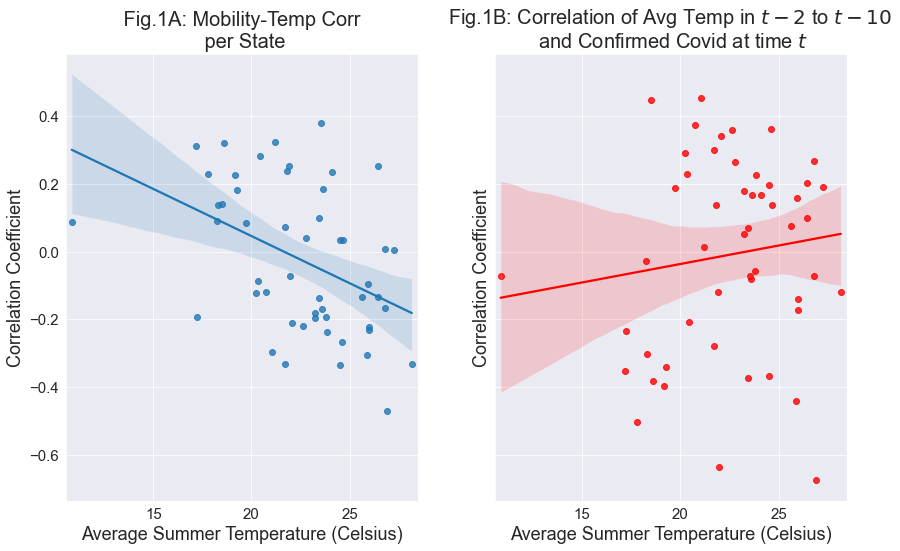

In [ ]:
plot_corr_side_by_side(mob_temp_corr.df, 'temperature_mean_avg', 'temp_rec_corrcoef', ' Fig.1A: Mobility-Temp Corr \n per State', 'Average Summer Temperature (Celsius)', 'Correlation Coefficient', temp_covid_corr.df, 'temperature_mean_avg', 'temp_covid_corr', 'Fig.1B: Correlation of Avg Temp in $t-2$ to $t-10$ \n and Confirmed Covid at time $t$','Average Summer Temperature (Celsius)', 'Correlation Coefficient')

### Analysis 3
The scatterplots in `Figure 2A` and `2B` aim to explore this relationship temporally, showing the 7-day rolling averages of temperature and percent change in COVID-19 cases in states with a positive recreation-temperature coefficient (A), and states with a negative recreation-temperature coefficient (B). It is apparent that states with a temperature mobility correlation coefficient greater than 1 have lower than average temperatures, which is in line with `Fig.1A`, and lower overall percent changes in COVID-19 cases. In `Fig.2A`, the percent change in confirmed cases rises around mid-June after the average temperature sharply rises, and drops as the temperature falls before the beginning of August. Additionally, after the temperature spike around June 15th, we do see a lagged increase in the number of cases in these states. While in line with expectations, the association between these two lines could be a spurious relationship due to exogenous factors, to be discussed in the limitations section. 

`Figure 2B` represents states with a negative correlation between temperature and recreational mobility. It shows temperature and percent change in COVID-19 cases coinciding, with cases rising directly before a large increase in temperature around June 15th. This may illustrate a level of disconnectedness between the two measures, as a temperature rise following an increase in COVID-19 cases could only be explained by coincidence or a confounding variable, given the direction of the effect. Additionally, after July 15th, the percent change in cases begins dropping, soon followed by temperature. At the beginning of June and in mid-August a non-lagged association between temperature and COVID-19 cases can be observed, an interesting phenomenon given that these are aggregated measures of states that only have a negative association between recreational mobility and temperature. There appears to be no inverse relationship between COVID-19 and average temperature among states who have negative correlation coefficients between temperature and recreational mobility.

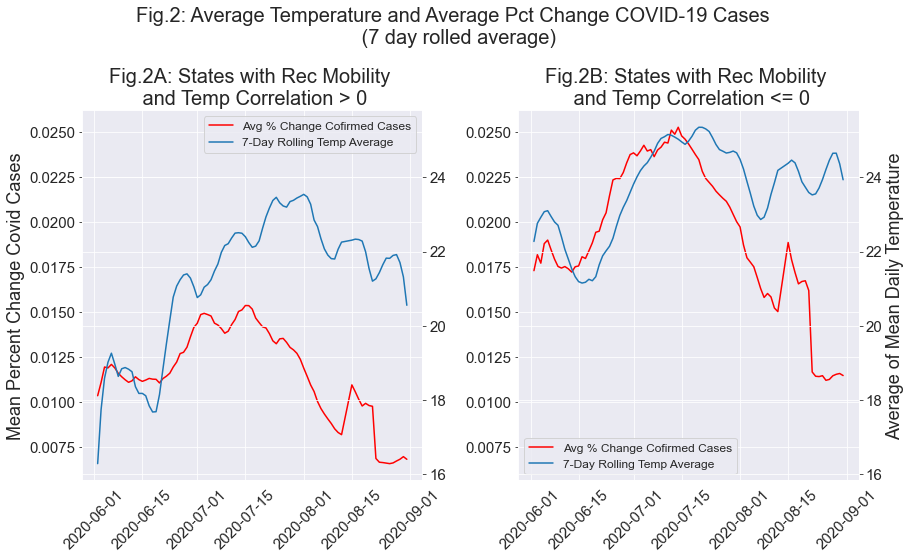

In [ ]:
temp_covid_rec_master.compare_timeseries_split_coef('date', 'rec_temp_coef_sign', 'weekly_rolled_cases', 'weekly_rolled_temp')

### Discussion
Relating these plots to the research question ($RQ_1$) surrounding the indirect impact of the summer temperature on COVID-19 cases, it appears that a state’s relative propensity to engage in recreational mobility during warmer weather fails to explain state-level differences in COVID-19 cases. Despite a lack of clear and robust results, the visualizations from this analysis do provide interesting findings. One such finding is `Fig.1.A`’s result documenting the impact of average summer temperature on a state’s recreational mobility during a temperature increase, with the hottest states reducing activity during warmer weather. Further, `Fig.2.A`  illustrates a lagged increase in COVID-19 cases after warmer temperatures for states with positive recreation-temperature correlation coefficients, in line the hypothesis ($H_1$). Potential reasons for the lack of expected results in other areas are to be discussed in the limitations section.

## Part I Limitations

This study visually explored the seasonal impact of summer through the lens of recreational mobility, but there are elements of the study which may explain the lack of strong results in the visualizations. One of the primary caveats of this study is that the relationship between recreational mobility, temperature, and COVID-19 cases was determined using correlation coefficients, which are not capable of rigorously describing statistical relationships in the data. While they summarize how variables change relative to each-other, strong claims involving causality or statistical significance are not possible from such measurements (Lieberson 1964). 

This study, which focuses on temperature, mobility statistics, and COVID-19, does not include policy impacts due to a lack of US state-level government measures, which may provide an avenue for continued research on the topic. This is an important limitation, as government policies may have influenced the relationship between mobility and temperature, due to the exogenous effects of shutdowns, re-openings, or limits on capacity in recreational spaces (Larue 2020). While changes in recreational mobility will be detected by the Google Mobility measurement, some of the impact of temperature on mobility may have been influenced by policies occurring at the same time, a potential confounder. 

A separate direction for future research could be the inclusion of individual state characteristics, one important trait being population density, which is unavailable on the state-level in the OxCovid Database. Prior research has found that population density is a strong indicator of COVID-19 cases and deaths, due to the increased risk of transmission in more dense areas (Desmet and Wacziarg 2020). This has implications for research on the role of recreational activity on COVID-19 cases, as increased recreational activity in areas of low population density would be expected to correlate less with confirmed cases than areas of high density. A future study exploring states with highly dense or sparse populations, or a city-level analysis exploring urban areas may help contribute to the research question at hand.

In `Figure 2`, which explores the average percent change in COVID-19 cases and average temperatures on a temporal scale, one limitation is that the aggregated average of temperature and COVID-19 cases may mask state-level effects. While this analysis aims to explain the summer outbreak across the entire United States, it may be the case that some individual states had experiences closer to the expected results, but were overshadowed by the general average. While this study aimed to observe whether a general trend could be observed across all states, a de-aggregated and targeted assessment of densely populated or weakly regulated states may help to explore these relationships.

# Part II: Impact of County-Level Racial Composition on COVID-19 Cases and Deaths 

### Background

In spite of a general decline in morbidity and mortality over the last century in the United States, the 'black health disadvantage' has been a well-documented phenomenon, and a cause for great concern for scientists and public health officials (Farmer and Ferraro 2005). COVID-19 is no exception to this trend, with state-level research finding that blacks contract and die of COVID-19 at substantially higher rates than other racial groups (Anyane-Yeboa, Sato, and Sakuraba 2020). This existing inequality risks being widened by the underrepresentation of blacks in research relative to their disease burden (Borno, Zhang, and Gomez 2020). Prior studies on the causes for this disparity have been focused on socio-economic status (SES), and have found that SES differences alone fail to explain the racial health disparity (Do et al. 2008). Given this limitation, research has turned towards physical location and context, where environmental exposure, built environment, and social conditions in areas with predominantly black populations explain a large part of the discrepancy in health outcomes (Do et al. 2008). 

This study seeks to build on prior literature by exploring the following question:

> ($RQ_2$): How does the racial composition of US counties relate to the number of confirmed cases and deaths per-capita from COVID-19?

While existing research on race and SARS-CoV-2 has been aimed at the state level, county-level research would add valuable information to help illustrate how racial compositions within states account for differences in harms caused by COVID-19. This study hypothesizes ($H_2$) that counties with higher percentages of black individuals experience more cases and deaths per capita from COVID-19, while counties with higher white population percentages experience the opposite relationship.

### Methodology

Prior to plotting cases and deaths based on the racial composition of county populations, it is important to note any distinct differences in the population densities or age distributions of counties with relatively more or less black individuals. Population density has been found to correlate positively with COVID-19 cases, therefore it would be a noteworthy caveat if one group was found to have counties with substantially different persons per square mile (Desmet and Wacziarg 2020). Additionally, understanding whether any systematic differences exist between the populations aged over 65 in each group would contribute valuable information on potential confounders, due to the increased risk of death from COVID-19 in older individuals (Goldstein and Lee 2020). 

The second section, which is the focus of this study, presents how the relative percentage of the black and white population in each county relates to the number of confirmed cases per capita in each county. An analysis of the same nature is then created for deaths per capita in each county. This analysis first finds the percentage of black and white individuals relative to the total population in each county. Due to absolute differences in black and white population percentages, this analysis standardizes each county based on a z-score to determine the prevalence of each race relative to the average of all counties. The y-axes of `Figure 4` and `Figure 5`, confirmed cases and deaths per capita, respectively, is calculated on a log scale to account for the high variation among values closer to zero, while still being able to account for the higher outlier cases.

#### Data

The data used in this analysis is from the United States Census Bureau API, specifically the American Community Survey 2014-2018 (ACS 14-18), which contains data on the total population, the population of each race, the land area, and the number of individuals over the age of 65 in each county (American Community Survey 2014-2018 5 Year Estimates 2019). The ACS 14-18 data is then merged with cumulative COVID-19 confirmed cases and deaths for each county on October 1st, 2020. In some states, such as Alaska, Louisiana, and Puerto Rico, areas that are functionally equivalent to counties are referred to as 'Boroughs', 'Parishes', 'Municipios', or other identifiers, which are inconsistently listed in ACS 14-18 and OxCovid19. These trailing words are found and removed to allow for clean merging and to minimize lost data. The statistics on COVID-19 were accessed from the OxCovid19 Database, with county-level cases and deaths reported by The New York Times (Mahdi et al. 2020).

## Analysis

### Importing Packages and Defining Functions

In [ ]:
import urllib
import json
import regex as re

class Analysis2:
    def __init__(self, df):
        #create Analysis class DataFrame
        self.df = df

    def clean_counties(self, col_name):
        #remove trailing words from counties and county-equivalents for merging
        for index, row in self.df.iterrows():
            if row[col_name] is not None:
                row = row.copy()
                if 'County' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) County", row[col_name])[0]
                elif 'Parish' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) Parish", row[col_name])[0]
                elif 'Borough' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) Borough", row[col_name])[0]
                elif 'Municipio' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) Municipio", row[col_name])[0]
                elif 'city' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) city", row[col_name])[0]
                elif 'City' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) City", row[col_name])[0]
                elif 'Census Area' in row[col_name]:
                    self.df.loc[index, col_name] = re.findall(r"^(.*?) Census Area", row[col_name])[0]

    def row1_to_heading(self):
        new_header = self.df.iloc[0]
        self.df = self.df[1:]
        self.df.columns = new_header
        
    def sum_missing_vals(self):
        #count missing values for each col
        display(self.df.isnull().sum())
    
    def get_incomplete_states(self, missing_val, state_var):
        #get states with missing val
        display(self.df.loc[self.df[missing_val].isnull()][state_var].value_counts())
    
    def drop_rows_missing_val(self, var):
        self.df.dropna(subset=[var], inplace=True)
        
    def create_pct_df(self, totals_df):
        #create DataFrame counting percents of input dataframe race columns
        self.df['county'] = totals_df.df['county_name']
        self.df['state']= totals_df.df['state_name']
        self.df['total_pop'] = totals_df.df['total_pop']
        self.df['LAND_AREA'] = totals_df.df['LAND_AREA']
        self.df['65_pop'] = totals_df.df['65_pop']
        substring_list = ['black', 'white']
        for col_name in totals_df.df:
            if any(substring in col_name for substring in substring_list):
                totals_df.df[col_name] = pd.to_numeric(totals_df.df[col_name])
                self.df[f'{col_name}_pct'] = totals_df.df[col_name]/totals_df.df['total_pop']
                
    def get_ratio(self, black_col, white_col):
        self.df[f'{black_col}/{white_col}'] = self.df[black_col]/self.df[white_col]
                
    def get_zscore(self, col):
        self.df[f'{col}_zscore'] =  (self.df[col] - self.df[col].mean())/self.df[col].std()
       
    def get_covid_per_person(self, covid_col, total_col):
        self.df[f'{covid_col}/{total_col}'] = self.df[covid_col]/self.df[total_col]
    
    def plot_pop_boxes(self, black_white_ratio, pop_density, age_var):
        sns.set_style('darkgrid')
        fig, (ax0, ax1) = plt.subplots(1, 2)
        fig.set_size_inches(18, 10)
        sns.boxplot(x= self.df[black_white_ratio] > self.df[black_white_ratio].mean(), y=self.df[pop_density], ax=ax0)
        sns.boxplot(x= self.df[black_white_ratio] > self.df[black_white_ratio].mean(), y=self.df[age_var], ax=ax1)
        ax0.set_yscale('log')
        ax0.set_title('Fig.3A: County Population Density Separated \n by Race Composition', fontsize=22)
        ax0.set_ylabel('Persons per Square Mile', fontsize=20)
        ax0.set_xlabel('Fig.3B: County Black-White Ratio Greater than Mean (0.18)', fontsize=20)
        ax1.set_title('Fig.3B: 65+ Individuals Separated by Race Composition', fontsize=22)
        ax1.set_ylabel('65+ Persons per Capita', fontsize=20)
        ax1.set_xlabel('County Black-White Ratio Greater than Mean (0.18)', fontsize=20)
        ax0.tick_params(axis="x", labelsize=20)
        ax0.tick_params(axis="y", labelsize=20)
        ax1.tick_params(axis="x", labelsize=20)
        ax1.tick_params(axis="y", labelsize=20)
        fig.tight_layout()


    def plot_covid_scatter(self, black_col, white_col, covid_col, stat_name, fignum, xlabel1, xlabel2, ylabel):
        fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
        fig.set_size_inches(20, 10)
        sns.regplot(x=black_col, y=covid_col, data=self.df, ax=ax0, color='b', line_kws = {'color':'red'})
        sns.regplot(x=white_col, y=covid_col, data=self.df, ax=ax1, color='g', line_kws = {'color':'red'})
        ax0.set_title(f"Figure {fignum}.A: County COVID-19 {stat_name} \n by Relative Black Pop'n (zscore)", fontsize=28)
        ax1.set_title(f"Figure {fignum}.B: County COVID-19 {stat_name} \n by Relative White Pop'n (zscore)", fontsize=28)
        ax0.set_yscale('log')
        ax1.set_yscale('log')
        ax0.set_xlabel(f'Z-Score of {xlabel1} Population %', fontsize=22)
        ax1.set_xlabel(f'Z-Score of {xlabel2} Population %', fontsize=22)
        ax0.set_ylabel(f'{ylabel} per Capita in County', fontsize=25)
        ax1.set_ylabel(f'{ylabel} per Capita in County', fontsize=25)
        ax0.tick_params(axis="x", labelsize=22)
        ax0.tick_params(axis="y", labelsize=22)
        ax1.tick_params(axis="x", labelsize=22)
        fig.tight_layout()



### Collect, Clean, and Wrangle Data

#### US Census API Data

In [ ]:
#comment out API call for replicability, data saved as .csv 

from keys import key
#select county name, total pop, black pop, white pop, land area, age 65+ population from ACS 14-18 data
columns='County_name,\
State_name,\
Tot_Population_ACS_14_18,\
NH_Blk_alone_ACS_14_18,\
NH_White_alone_ACS_14_18,\
LAND_AREA,\
Civ_noninst_pop_65P_ACS_14_18'

key = key

In [ ]:
#make API call and translate into DataFrame
api_call = f"https://api.census.gov/data/2020/pdb/statecounty?get={columns}&for=County:*&key={key}"
req = urllib.request.Request(api_call)
infile = urllib.request.urlopen(req)
census_data = json.loads(infile.read())
census_data = pd.DataFrame(census_data)
census_data.to_csv('census_data.csv')

In [ ]:
census_data = pd.read_csv('census_data.csv')
census_data = Analysis2(census_data)

In [ ]:
census_data.df.to_csv('census_data3.csv')

In [ ]:
#make first row into heading, original df has column names in row 1
census_data.row1_to_heading()

#rename columns for clarity
census_data.df.rename(columns = {'County_name': 'county_name', 
                                 'State_name':'state_name', 
                                 'Tot_Population_ACS_14_18': 'total_pop',
                                 'NH_Blk_alone_ACS_14_18' : 'black_pop',
                                 'NH_White_alone_ACS_14_18': 'white_pop',
                                'Civ_noninst_pop_65P_ACS_14_18': '65_pop'}, inplace=True)


In [ ]:
census_data.df.to_csv('census_data3.csv')

In [ ]:

#keep relevant columns
#census_data.df = census_data.df[['county_name', 'state_name', 'total_pop', 'black_pop', 'white_pop', 'LAND_AREA', '65_pop']]

#remove trailing words from county names
census_data.clean_counties('county_name')

#view all states with empty county values
#census_data.get_incomplete_states('county_name', "state_name")

#observe all missing values in dataframe
#census_data.sum_missing_vals()

#drop rows with missing county vals
census_data.drop_rows_missing_val('county_name')

#view states missing total_pop column value
census_data.get_incomplete_states('total_pop', "state_name")

#remove rows missing total_pop from dataframe
census_data.drop_rows_missing_val('total_pop')

census_data.df.reset_index(inplace=True)

#make columns numeric for calculations
census_data.df['total_pop'] = pd.to_numeric(census_data.df['total_pop'])
census_data.df['black_pop'] = pd.to_numeric(census_data.df['black_pop'])
census_data.df['white_pop'] = pd.to_numeric(census_data.df['white_pop'])
census_data.df['LAND_AREA'] = pd.to_numeric(census_data.df['LAND_AREA'])
census_data.df['65_pop'] = pd.to_numeric(census_data.df['65_pop'])

#create new dataframe, to include percentage of racial make-up
pct_df = Analysis2(pd.DataFrame())

#create pct dataframe using class function which uses county name, 
#county pop, and race pops to generate percentages for each
pct_df.create_pct_df(census_data)

#standardize population percentages with z-score for black and white populations
pct_df.get_zscore('black_pop_pct')
pct_df.get_zscore('white_pop_pct')

In [ ]:
census_data.df.to_csv('census_data2.csv')

### Merge Percentages and Z-Scores with COVID-19 

#### OxCovid19 Data

In [ ]:
# connect to OxCovid Database to acquire county-level confirmed cases and deaths from NYT source
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""
SELECT epidemiology.COUNTRYCODE, \
epidemiology.adm_area_2, \
epidemiology.adm_area_1, \
EPIDEMIOLOGY.CONFIRMED, \
epidemiology.DEAD, \
epidemiology.date \
FROM EPIDEMIOLOGY WHERE EPIDEMIOLOGY.date='2020-10-01' AND EPIDEMIOLOGY.country = 'United States' \
AND EPIDEMIOLOGY.source = 'USA_NYT' \
ORDER BY EPIDEMIOLOGY.date
""")

us_covid = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
us_covid.rename(columns={'adm_area_1':'state', 'adm_area_2':'county'}, inplace=True)
us_covid = Analysis2(us_covid)

In [ ]:
#clean county names to remove trailing words for merging
us_covid.clean_counties('county')
#create new dataframe that merges demographic percentage and zscores with the covid statistics on each county
county_race_covid = pct_df.df.merge(us_covid.df[['confirmed', 'county', 'state', 'dead']], left_on=['county', 'state'], right_on=['county', 'state'])

#create Analysis2 object from county_race_covid
county_race_covid = Analysis2(county_race_covid)

#get black-white ratio, pop density, and 65+ density
county_race_covid.get_ratio('black_pop_pct', 'white_pop_pct')
county_race_covid.get_ratio('total_pop', 'LAND_AREA')
county_race_covid.get_ratio('65_pop', 'total_pop')

#generate covid cases per person and deaths per person for each county
county_race_covid.get_covid_per_person('confirmed', 'total_pop')
county_race_covid.get_covid_per_person('dead', 'total_pop')

In [ ]:
county_race_covid.df[['black_pop_pct', 'white_pop_pct']].describe().loc[['mean', 'min', 'max']]

,black_pop_pct,white_pop_pct
mean,0.088425,0.766740
min,0.000000,0.007278
max,0.874123,1.000000


## Results

### Population Density of Counties based on Race Ratios

The boxplots in `Fig.3A` summarize the population densities of counties with a black to white ratio less than versus greater than the total country mean. Due to dramatically varying population densities across US counties, a log scale allows for a clearer side-by-side comparison. The boxplots in `Fig.3B` depict the amount of individuals 65 or older per capita based on the same grouping. From these visualizations we see that counties with a black-white ratio above the mean, labelled 'True', tend to have greater population densities, with a median of 64.5 individuals per square mile compared to 40. We additionally observe that counties with a black-white ratio above the mean tend to have fewer individuals aged 65 or older per capita, with a median of 0.15 compared to 0.17. Interpreting these results, we may expect that counties above the mean black-white ratio would tend to experience more cases per capita due to density, while the younger population may convey a degree of protection from COVID-19 deaths.

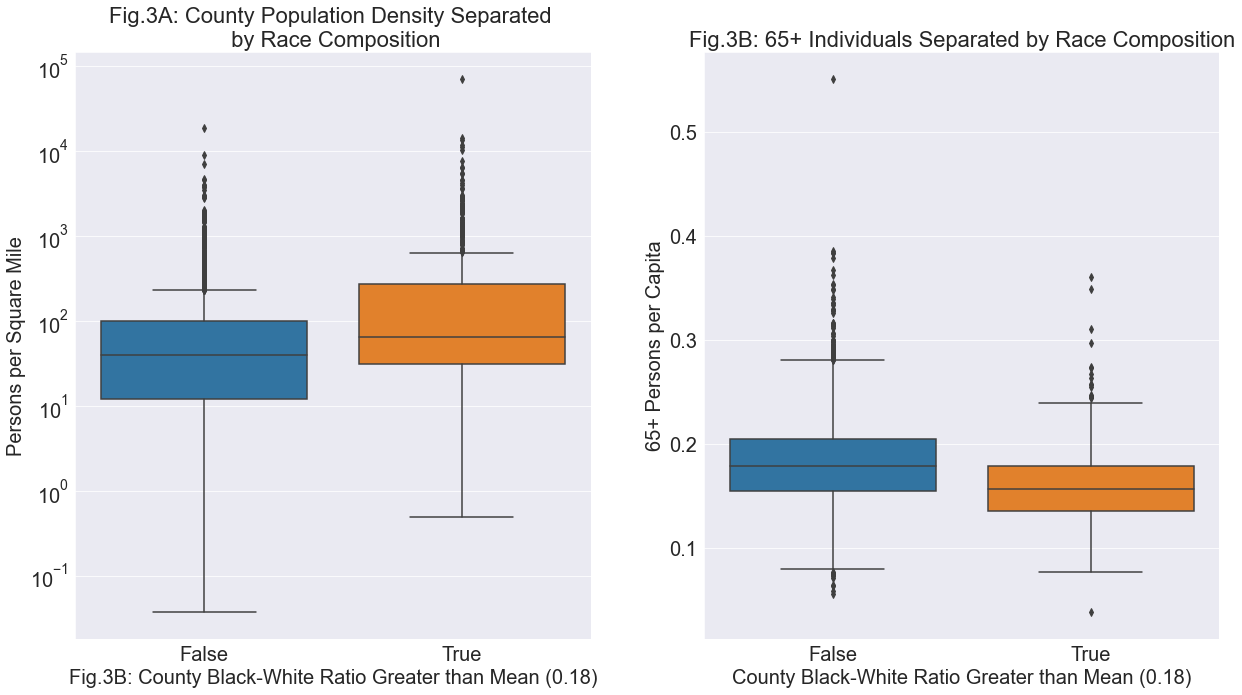

In [ ]:
county_race_covid.plot_pop_boxes('black_pop_pct/white_pop_pct', 'total_pop/LAND_AREA', '65_pop/total_pop')

### COVID-19 Cases and Deaths by Black and White Prevalence in County

In `Figure 4`,  we see two scatter plots representing each county's confirmed cases per capita, on a log scale, separated on the x-axis by their relative population percentage of black and white individuals, respectively. In each plot, the point 0 on the x-axis represents the mean percentage of the black and white population in each county, which is 0.088 in `Figure 4A`, and 0.766 in `Figure 4B`. Each integer on the x-axis represents the number of standard deviations each county lies from the mean race percentage. The logarithm of confirmed cases per capita shows that as the relative amount of black individuals in counties increases, there is a positive association with the log-scaled number of confirmed cases, in line with ($H_2$). The relationship is reversed when observing the white population percentages, with counties tending to experience less cases as the proportion of white individuals increases.

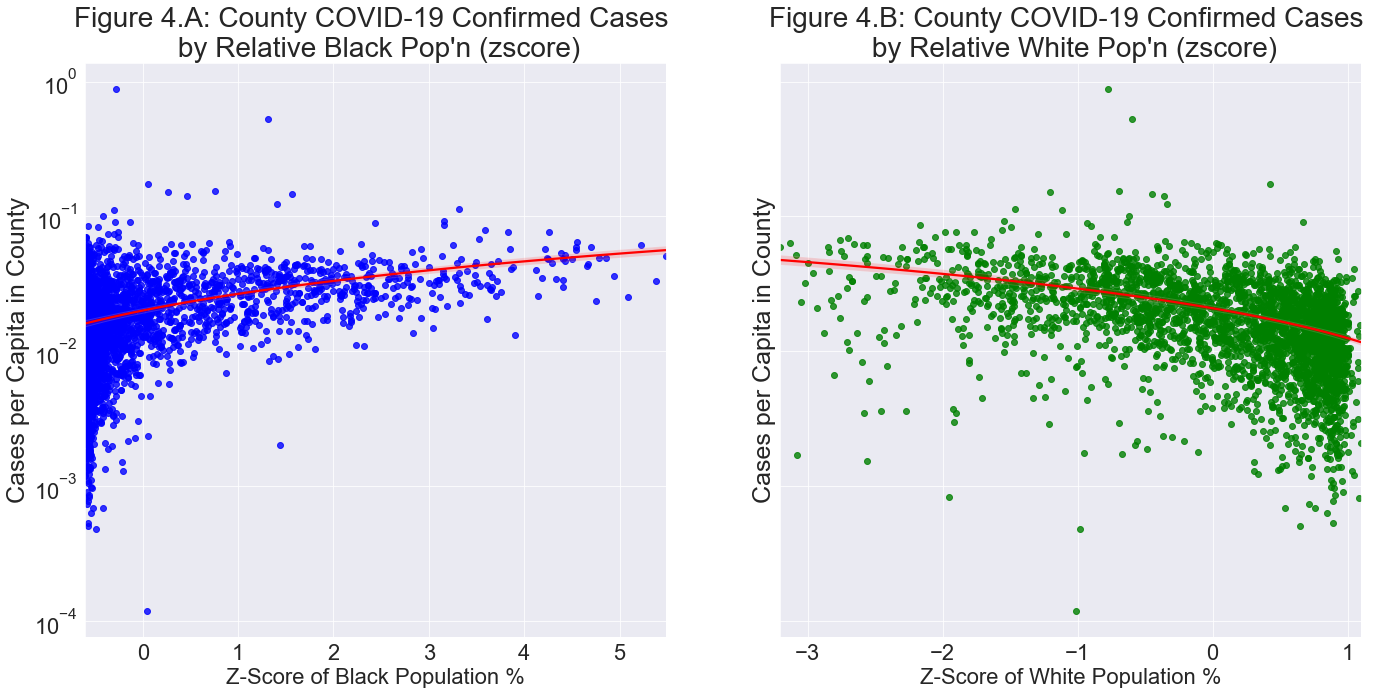

In [ ]:
sns.set_style('darkgrid')
county_race_covid.plot_covid_scatter('black_pop_pct_zscore', 'white_pop_pct_zscore', 'confirmed/total_pop', 'Confirmed Cases', 4, 'Black', 'White', 'Cases')

In `Figure 5`, we again observe two scatter plots showing the standardized percent of black and white populations in each county. Rather than log-scaled confirmed cases per capita as in `Figure 4`, the y-axis is the log-scaled deaths per capita from COVID-19 in each county. There appears to be an even stronger relation than in the former, with the log of deaths per capita increasing with the z-score of the black population in each county, conforming to the hypothesis ($H_2$).  This relationship is reversed in the adjacent plot (`Fig.5B`), with log deaths per capita sharply decreasing as the standardized percentage of white individuals in a county increases. 

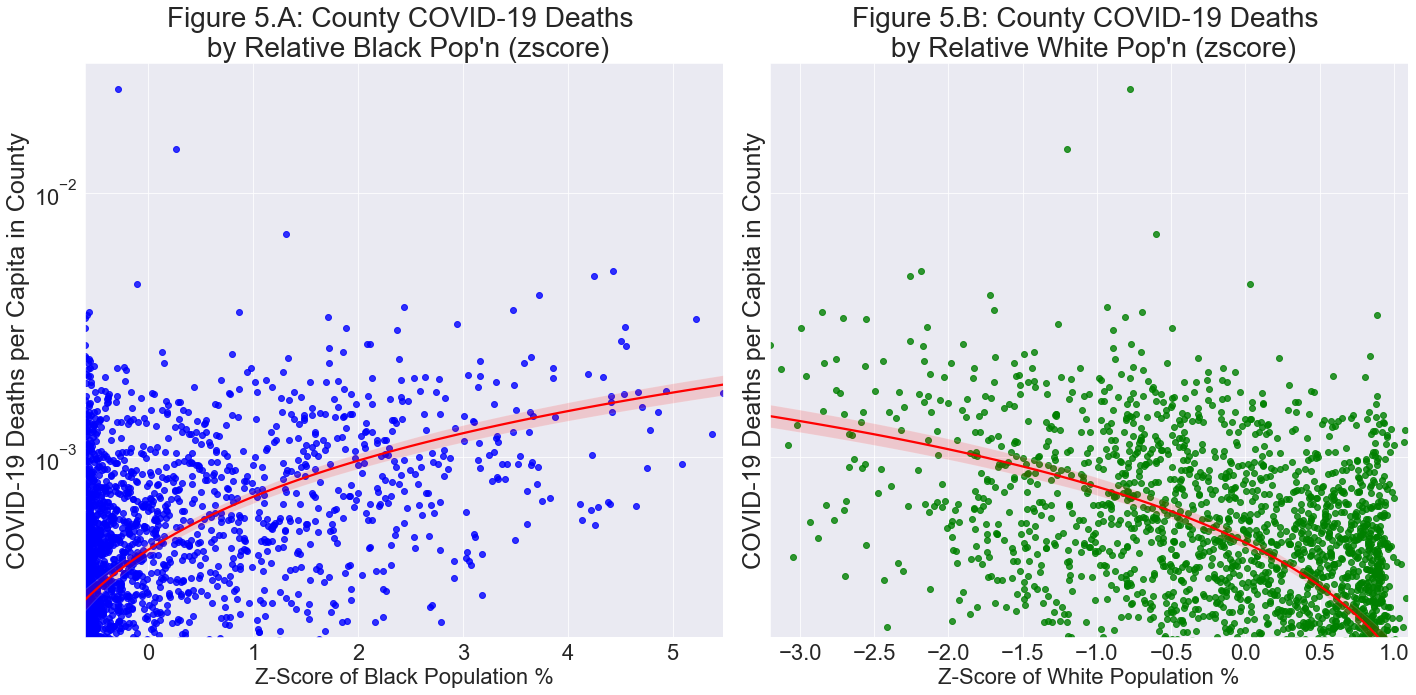

In [ ]:
sns.set_style('darkgrid')
county_race_covid.plot_covid_scatter('black_pop_pct_zscore', 'white_pop_pct_zscore', 'dead/total_pop', 'Deaths', 5, 'Black', 'White', 'COVID-19 Deaths')

The differences between the x-axes in both sets of side-by-side plots can be explained by observing the differences in absolute percentages of black and white individuals. The high concentration of counties in `Fig.4A` and `Fig.5A` on the left side of the plots is due to the high number of counties with 0% or slightly higher black population percentages. This phenomenon explains the right skewness of the scatterplot, as the percentage cannot go below zero, and these zero values pull the mean and standard deviation of black population percentages down. The opposite is true for the `Fig.4B` and `Fig.5B`. where the maximum z-score is 1.09 standard deviations above the mean (76.6%), which represents counties with 99.8% white populations. The lowest population percentage of white individuals Is 0.007%, which explains the large negative portion on the x-axis. To understand the influence of such extreme values, a z-score was calculated from the median during the creation of this study, which is more robust to outliers, with highly similar results. Due to the similarity of the two measures, the z-score was calculated using the mean, which is the more commonly applied method of standardization. 


### Discussion
The findings from `Fig.4` and `Fig.5` depict the racial health disparity as explored in the prior literature on the subject, and appear to confirm the hypothesis ($H_2$) (Farmer and Ferraro 2005).  We see that for both confirmed COVID-19 cases and deaths, counties that have relatively more black individuals have experienced more cases and deaths per capita than states with relatively fewer black people. This relationship is reversed when observing white individuals in the United States, with fewer cases and deaths being observed in states with higher proportions of white individuals. While more cases per capita could be partially explained by the greater population density of counties that have relatively more black individuals, the stark difference in death rate despite generally fewer individuals under the age of 65 per capita is highly concerning. This analysis contributes to prior work by showing that the racial health gap extends not only to state-level statistics, but is present on a county-level scale.

## Part II Limitations

A primary limitations of this study, and an avenue for future research on racial health disparities, is incorporating county-level COVID-19 hospitalization data, which was unavailable in the OxCovid19 Database or the Census Bureau API. An exploration of this data in relation to COVID-19 and the racial composition of counties may help illustrate a key portion of the health gap – access to hospital care (Verhagen et al. 2020). This analysis highlights that COVID-19 confirmed cases and deaths both increase as the proportion of black individuals in a county increases, a claim which hospitalization data may help support. For example, fewer hospitalization per capita as the proportion of black individuals increases may help to explain the findings of more deaths in these counties. 

The racial health gap in the United States is not specific to its black population, but prevalent among Hispanics and Indigenous Populations (Buchmueller et al. 2016; Stoner et al. 2015). The decision to focus  on black and white health relationships was motivated by a desire to tackle the research question with sufficient depth, given the cited literature and concern of the disproportionate impacts of COVID-19 on black individuals. Given the scarcity of COVID-19 research concerning racial and ethnic minorities, expanding the approaches used in this study to these populations may help to unconver the inflammatory effects of the pandemic on racial health inequalities.

# References
U.S. Census Bureau. American Community Survey 2014-2018 5 Year Estimates. 2019.

Anyane-Yeboa, A., T. Sato, and A. Sakuraba. 2020. “Racial Disparities in COVID-19 Deaths Reveal Harsh Truths about Structural Inequality in America.” Journal of Internal Medicine 288(4): 479–80.

Borno, Hala T., Sylvia Zhang, and Scarlett Gomez. 2020. “COVID-19 Disparities: An Urgent Call for Race Reporting and Representation in Clinical Research.” Contemporary Clinical Trials Communications 19: 2451–8654.

Buchmueller, Thomas C., Zachary M. Levinson, Helen G. Levy, and Barbara L. Wolfe. 2016. “Effect of the Affordable Care Act on Racial and Ethnic Disparities in Health Insurance Coverage.” American Journal of Public Health 106(8): 1416–21.

Desmet, K, and R Wacziarg. 2020. UNDERSTANDING SPATIAL VARIATION IN COVID-19 ACROSS THE UNITED STATES. Cambridge, MA.

Do, D. Phuong et al. 2008. “Does Place Explain Racial Health Disparities? Quantifying the Contribution of Residential Context to the Black/White Health Gap in the United States.” Social Science and Medicine 67(8): 1258–68.

Farmer, Melissa M, and Kenneth F Ferraro. 2005. “Are Racial Disparities in Health Conditional on Socioeconomic Status?” Social Science & Medicine 60: 191–204.

Goldstein, Joshua R., and Ronald D. Lee. 2020. “Demographic Perspectives on the Mortality of COVID-19 and Other Epidemics.” Proceedings of the National Academy of Sciences of the United States of America 117(36): 35–41.

Kim, Soyoung, Youngsuk Ko, Yae Jean Kim, and Eunok Jung. 2020. “The Impact of Social Distancing and Public Behavior Changes on COVID-19 Transmission Dynamics in the Republic of Korea.” PLoS ONE 15(9): e0238684.

Larue, Bruno. 2020. “Labor Issues and COVID‐19.” Canadian Journal of Agricultural Economics/Revue canadienne d’agroeconomie 68(2): 231–37

Lauer, Stephen A. et al. 2020. “The Incubation Period of Coronavirus Disease 2019 (COVID-19) from Publicly Reported Confirmed Cases: Estimation and Application.” Annals of Internal Medicine 172(9): 577–82.

Lieberson, Stanley. 1964. “Limitations in the Application of Non-Parametric Coefficients of Correlation.” American Sociological Review 29(5): 744.

Adam Mahdi, Piotr Błaszczyk, Paweł Dłotko, Dario Salvi, Tak-Shing Chan, John Harvey, Davide Gurnari, Yue Wu, Ahmad Farhat, Niklas Hellmer, Alexander Zarebski, Bernie Hogan, Lionel Tarassenko. 2020. "Oxford COVID-19 Database: a multimodal data repository for better understanding the global impact of COVID-19". University of Oxford.

Merow, Cory, and Mark C. Urban. 2020. “Seasonality and Uncertainty in Global COVID-19 Growth Rates.” Proceedings of the National Academy of Sciences 117(44): 202008590

Ratnesar-Shumate, Shanna et al. 2020. “Simulated Sunlight Rapidly Inactivates SARS-CoV-2 on Surfaces.” Journal of Infectious Diseases 222(2): 214–22.

Salvador, Cristina E. et al. 2020. “Relational Mobility Predicts Faster Spread of COVID-19: A 39-Country Study.” Psychological Science 31(10): 1236-1244.

Singer, Merrill, Nicola Bulled, Bayla Ostrach, and Emily Mendenhall. 2017. “Syndemics and the Biosocial Conception of Health.” The Lancet 389(10072): 941–50.

Stoner, Lee et al. 2015. “The Indigenous Health Gap: Raising Awareness and Changing Attitudes.” Perspectives in Public Health 135(2): 68–70.

Verhagen, Mark et al. 2020. “Forecasting Spatial, Socioeconomic and Demographic Variation in COVID-19 Health Care Demand in England and Wales” ed. David Brazel. BMC Medicine 18, 203.

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel
import io
from IPython.nbformat import current

def notebook_path():
    
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+
                    'api/sessions?token='+srv['token'])
            
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],
                                        sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

with io.open(notebook_path(), 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        if cell['source'][:12] == "# References":
            continue
        else:
            word_count += len(cell['source'].replace('#','')
                              .lstrip().split(' '))

print(f"The word count, excluding references, is {word_count}")

The word count, excluding references, is 3497
